<a href="https://colab.research.google.com/github/fouad89/30-days-of-ml-kaggle-competition/blob/main/08_02_more_improvements.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Version 8
In this notebook, and exploration of the data to find feature importance and which columns affect the results the most.

** using new params 
<code>
xgb_params = {
        'learning_rate': 0.03628302216953097,
        'subsample': 0.7875490025178,
        'colsample_bytree': 0.11807135201147,
        'max_depth': 3,
        'booster': 'gbtree', 
        'reg_lambda': 0.0008746338866473539,
        'reg_alpha': 23.13181079976304,
        'random_state':0,
        'n_estimators':10000
        }
</code>

## Results
cat2 has the lowest feature importance cat2: 0.005
Removing cat2 improved the results slightly.

In [18]:
import tensorflow as tf
tf.test.is_built_with_cuda()
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [63]:
# reading data from google drive 
# data paths whether notebook is run locally or google colab
import os
try:
    from google.colab import drive
    drive.mount('/content/drive')
    COMPETETION_PATH = "/content/drive/MyDrive/30-days-of-ml-competition1"
    TRAIN_DATA_PATH = "/content/drive/MyDrive/30-days-of-ml-competition1/data/train.csv"
    TEST_DATA_PATH = "/content/drive/MyDrive/30-days-of-ml-competition1/data/test.csv"
    OUTPUT_PATH = "/content/drive/MyDrive/30-days-of-ml-competition1/output"
except:
    TRAIN_DATA_PATH = os.path.join("data", "train.csv")
    TEST_DATA_PATH = os.path.join("data", "test.csv")
    OUTPUT = 'output'

print(f"Training Path {TRAIN_DATA_PATH}")
print(f"Testing Path {TEST_DATA_PATH}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training Path /content/drive/MyDrive/30-days-of-ml-competition1/data/train.csv
Testing Path /content/drive/MyDrive/30-days-of-ml-competition1/data/test.csv


In [3]:

# library imports
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as pp
import os
from math import *

# preprocessing\
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# modeling
from xgboost import XGBRegressor

# evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [4]:
# reading the data
df = pd.read_csv(TRAIN_DATA_PATH, index_col='id')
X_test = pd.read_csv(TEST_DATA_PATH, index_col='id')

In [5]:
print(f"Shape of Training Data {df.shape}")
print(f"Shape of Testing Data {X_test.shape}")

Shape of Training Data (300000, 25)
Shape of Testing Data (200000, 24)


In [6]:
y = df.target.copy()
X = df.drop('target', axis=1).copy()

In [7]:
def create_num_cols(df):
    return df.select_dtypes(exclude="object").columns.to_list()
def create_cat_cols(df):
    return [cname for cname in df.columns if (df[cname].dtypes=="object")]

num_cnames = create_num_cols(X)
cat_cnames = create_cat_cols(X)
all_cnames = num_cnames + cat_cnames

print(f"There are {len(num_cnames)} Numerical columns")
print(f"There are {len(cat_cnames)} Categorical Columns")
print(f"In total, there are {len(all_cnames)} columns")

There are 14 Numerical columns
There are 10 Categorical Columns
In total, there are 24 columns


# EDA

In [11]:
df.describe()

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,0.527335,0.460926,0.490498,0.496689,0.491654,0.510526,0.467476,0.537119,0.498456,0.474872,0.474492,0.473216,0.494561,0.508273,8.241979
std,0.230599,0.214003,0.253346,0.219199,0.240074,0.228232,0.210331,0.218140,0.239920,0.218007,0.255949,0.222022,0.247292,0.222950,0.746555
min,-0.118039,-0.069309,-0.056104,0.130676,0.255908,0.045915,-0.224689,0.203763,-0.260275,0.117896,0.048732,0.052608,-0.074208,0.151050,0.140329
25%,0.405965,0.310494,0.300604,0.329783,0.284188,0.354141,0.342873,0.355825,0.332486,0.306874,0.276017,0.308151,0.289074,0.300669,7.742071
50%,0.497053,0.427903,0.502462,0.465026,0.390470,0.488865,0.429383,0.504661,0.439151,0.434620,0.459975,0.433812,0.422887,0.472400,8.191373
75%,0.668060,0.615113,0.647512,0.664451,0.696599,0.669625,0.573383,0.703441,0.606056,0.614333,0.691579,0.642057,0.714502,0.758447,8.728634
max,1.058443,0.887253,1.034704,1.039560,1.055424,1.067649,1.111552,1.032837,1.040229,0.982922,1.055960,1.071444,0.975035,0.905992,10.411992


In [12]:
def plot_corr(df):
    """Plotting correlation for a given dataframe."

    Args:
        df (dataframe): get the plot for the correlation
    """
    plt.figure(figsize=(15,15))
    mask = np.triu(np.ones(df.corr().shape))
    sns.heatmap(df.corr(), annot=True, mask=mask)


def count_plots_cat(df, num_rows=ceil(len(cat_cnames)/2),num_cols =2 , col_names=cat_cnames):
    """plotting the value counts for categorical variables

    Args:
        df (dataframe): dataframe
        num_rows (int, optional): Number of rows for the ploat. Defaults to ceil(len(cat_cnames)/2).
        num_cols (int, optional): Number of columns for the plotting. Defaults to 2.
        col_names (list, optional): the categorical column names. Defaults to cat_cnames.
    """
    fix, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15,30))
    axes = axes.ravel()
    for i in range(len(col_names)):
        col = col_names[i]
        sns.countplot(df[col], ax=axes[i]);
        axes[i].set_title(f"{col} Distribution");
        axes[i].set_yticklabels([]) # removing labels
        axes[i].set_yticks([]) # removign ticks
        axes[i].set_ylabel("PCT %")
        # removing borders 
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
        axes[i].spines['bottom'].set_visible(False)
        axes[i].spines['left'].set_visible(False)
        # showing values in plot
        for patch in axes[i].patches:
            # get the height of the patch
            h = patch.get_height()
            axes[i].text(patch.get_x()+patch.get_width()/2,
                        h+8,'{:.2f}%'.format(h*100/len(df)),
                    fontsize = 12,ha = 'center')




In [ ]:
plot_corr(df)

In [ ]:
count_plots_cat(df)

## Modeling

In [70]:
def output_submission(prediction, file_name):
    """creating a kaggle submission file

    Args:
        prediction (array): an array of predictions of the test dataset
        file_name (string): a string for the name without the extension
    """
    my_submission = pd.DataFrame({'target': prediction},
                                 index=X_test.index)
    #my_submission.set_index('id')
    file_path = os.path.join(OUTPUT_PATH,file_name)
    my_submission.to_csv(f'{file_path}.csv')
    print(f'A submission file has been made at {file_path}')

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state=0)

In [22]:
xgb_params = {
        'learning_rate': 0.03628302216953097,
        'subsample': 0.7875490025178,
        'colsample_bytree': 0.11807135201147,
        'max_depth': 3,
        'booster': 'gbtree', 
        'reg_lambda': 0.0008746338866473539,
        'reg_alpha': 23.13181079976304,
        'random_state':0,
        'n_estimators':10000
        
        
    }
    
model= XGBRegressor(**xgb_params,
                    objective='reg:squarederror')

preprocessor = ColumnTransformer(transformers=[
    ('cat', OrdinalEncoder(), cat_cnames),
], remainder='passthrough')


xgb_pipeline = Pipeline(steps=[
    ('prep', preprocessor),
    ('model', model)
])

In [23]:
xgb_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('prep',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  OrdinalEncoder(categories='auto',
                                                                 dtype=<class 'numpy.float64'>),
                                                  ['cat0', 'cat1', 'cat2',
                                                   'cat3', 'cat4', 'cat5',
                                                   'cat6', 'cat7', 'cat8',
                                                   'cat9'])],
                                   verbose=False)),
                ('model',
                 XGBRegressor(base_score=0.5, boo...
                              importance_type='gain',
                              learning_rate=0.036283

In [24]:
def model_eval(model, X_v, y_v):
    predictions = model.predict(X_v)
    rmse = mean_squared_error(y_v, predictions)**0.5
    print(f"RMSE: {rmse}")
    return rmse
    
    

In [33]:
# predictions = xgb_pipeline.predict(X_valid)
# rmse = mean_squared_error(y_valid, predictions)**0.5
rmse = model_eval(xgb_pipeline, X_valid, y_valid)

RMSE: 0.7184398773202069


In [27]:
xgb_pipeline['model'].feature_importances_

array([0.00948562, 0.08217142, 0.00720633, 0.01156965, 0.00326275,
       0.00917876, 0.00386571, 0.00374016, 0.04286325, 0.01097175,
       0.03351942, 0.02708367, 0.075363  , 0.04352359, 0.04758358,
       0.04855086, 0.02635011, 0.06044033, 0.0313333 , 0.07980752,
       0.12869087, 0.04524225, 0.12788007, 0.04031598], dtype=float32)

In [31]:

feature_importance = xgb_pipeline['model'].feature_importances_
print("Feature Importances")
least_importance = {}
for cname, importance in zip(X.columns, feature_importance):
    print(f"{cname}: {importance:0.4f}")
    if importance < 0.005:
        least_importance[cname] = importance
print('\n',least_importance)


Feature Importances
cat0: 0.0095
cat1: 0.0822
cat2: 0.0072
cat3: 0.0116
cat4: 0.0033
cat5: 0.0092
cat6: 0.0039
cat7: 0.0037
cat8: 0.0429
cat9: 0.0110
cont0: 0.0335
cont1: 0.0271
cont2: 0.0754
cont3: 0.0435
cont4: 0.0476
cont5: 0.0486
cont6: 0.0264
cont7: 0.0604
cont8: 0.0313
cont9: 0.0798
cont10: 0.1287
cont11: 0.0452
cont12: 0.1279
cont13: 0.0403

 {'cat4': 0.0032627492, 'cat6': 0.0038657056, 'cat7': 0.0037401589}


In [35]:
def plot_importances(pipeline, col_names):
    feature_importance = pipeline['model'].feature_importances_

    plt.figure(figsize=(12,15))
    plt.barh(col_names, feature_importance)
    plt.title(f"Feature Importances")
    plt.xlabel("Feature Importance")

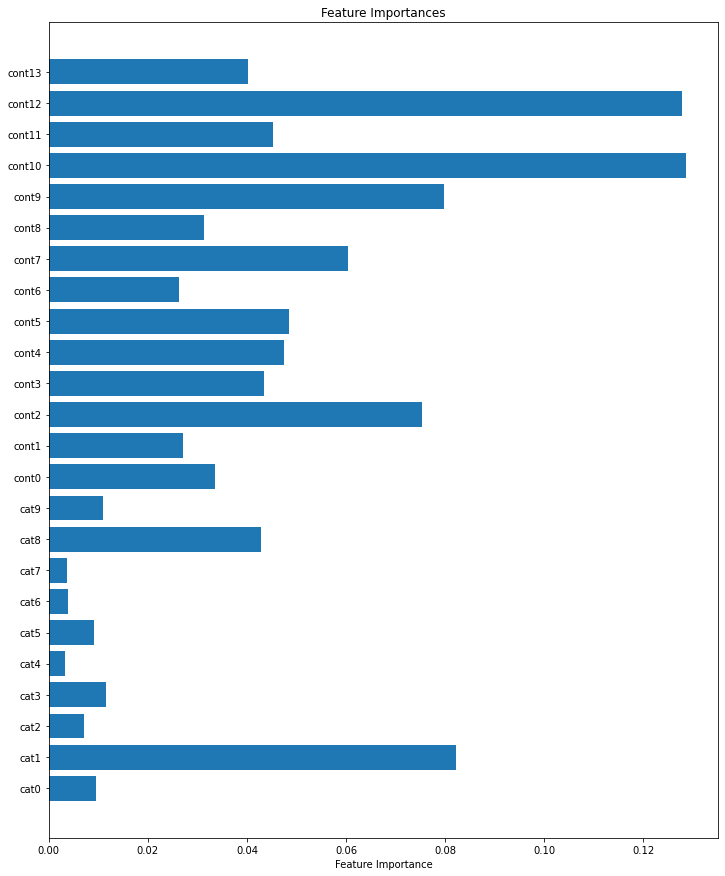

In [36]:
plot_importances(xgb_pipeline, X.columns)

## Data change

In [48]:
y2 = df.target.copy()
cols_to_drop = list(least_importance.keys())
print(cols_to_drop)
X2 = df.drop(cols_to_drop, axis=1).copy()
X2.drop('target', axis=1, inplace=True)
print(X.shape)
X2_train, X2_valid, y2_train, y2_valid = train_test_split(X2, y2, test_size=0.2, random_state=0)

['cat4', 'cat6', 'cat7']
(300000, 24)


In [50]:
X2_train.shape

(240000, 21)

In [53]:
num_cnames2 = create_num_cols(X2)
cat_cnames2 = create_cat_cols(X2)
print(cat_cnames2)
print(num_cnames2)

['cat0', 'cat1', 'cat2', 'cat3', 'cat5', 'cat8', 'cat9']
['cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13']


In [57]:
preprocessor2 = ColumnTransformer([
    ('num', StandardScaler(), num_cnames2),
    ('cat', OrdinalEncoder(), cat_cnames2)
], remainder='passthrough')

pipe02 = Pipeline(steps=[
    ('preprocessor2', preprocessor2),
    ('model', model)
])

In [59]:
# evaluation
pipe02.fit(X2_train, y2_train)
rmse02 = model_eval(pipe02, X2_valid, y2_valid)

Pipeline(memory=None,
         steps=[('preprocessor2',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['cont0', 'cont1', 'cont2',
                                                   'cont3', 'cont4', 'cont5',
                                                   'cont6', 'cont7', 'cont8',
                                                   'cont9', 'cont10', 'cont11',
                                                   'cont12', 'cont13']),
                                                 ('cat',
              

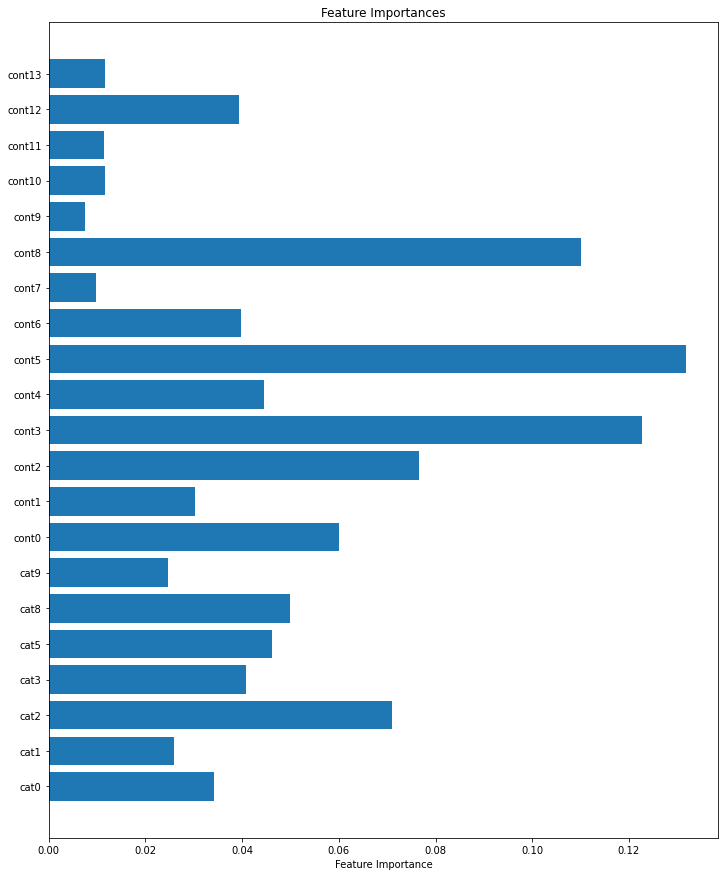

In [73]:
plot_importances(pipe02, X2.columns)

In [75]:
low_importances = {}
importances02 = pipe02['model'].feature_importances_

for cname, importance in zip(X2.columns, importances02):
    print(f"{cname}: {importance}")
    if importance < 0.01:
        low_importances[cname] = importance

print("\n", low_importances)

cat0: 0.03424811735749245
cat1: 0.025887954980134964
cat2: 0.07104084640741348
cat3: 0.04090540483593941
cat5: 0.04617612808942795
cat8: 0.04993564262986183
cat9: 0.02459382452070713
cont0: 0.060116540640592575
cont1: 0.030266044661402702
cont2: 0.07660751789808273
cont3: 0.1227099820971489
cont4: 0.04453575238585472
cont5: 0.13188880681991577
cont6: 0.03985213860869408
cont7: 0.009750093333423138
cont8: 0.11015648394823074
cont9: 0.007476001046597958
cont10: 0.01155666634440422
cont11: 0.011338609270751476
cont12: 0.03931260108947754
cont13: 0.011644767597317696

 {'cont7': 0.009750093, 'cont9': 0.007476001}


In [72]:
pipe02.fit(X2, y2)
X2_test = X_test.drop(cols_to_drop, axis=1).copy()
preds02 = pipe02.predict(X2_test)
output_submission(preds02, "submission807")


A submission file has been made at /content/drive/MyDrive/30-days-of-ml-competition1/output/submission807


In [91]:
pipe02

Pipeline(memory=None,
         steps=[('preprocessor2',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['cont0', 'cont1', 'cont2',
                                                   'cont3', 'cont4', 'cont5',
                                                   'cont6', 'cont7', 'cont8',
                                                   'cont9', 'cont10', 'cont11',
                                                   'cont12', 'cont13']),
                                                 ('cat',
              

In [76]:
## Removing columns with very low importance